## Causal estimation

This notebook provides an attempt at causal estimation of the role of gender in wage inequalities. 
As a reminder, this dataset  - `Description des emplois salariés en 2021` is taken from the `Insee` website at the following link : <https://www.insee.fr/fr/statistiques/7651654#dictionnaire>.
We aim to study the effect of gender on the level of wages, depending on several variables.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected= True)
import plotly.express as px
import seaborn as sns
import scipy as sp

In [70]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.linear_model import RidgeCV

`Warning` : This code should be run after the [import and formating notebook](test_import_données.ipynb).

In [3]:
base = pd.read_csv("INSEE_DATA_TREATED.csv")

/tmp/ipykernel_1312/440333465.py:1: DtypeWarning:

Columns (1,2,4,25,32,33) have mixed types. Specify dtype option on import or set low_memory=False.



## First method: a penalized linear model 

This step is useful to get a first broad idea of which covariates are important to predict wages.

First, we split the sample into a train and a test dataset. 
Only the train dataset will be used to fit the model.

In [ ]:
X = base[all_columns]
X.describe(include="all")

We modify the target variable (wage) by replacing the 0s with 1s that can be handled when transformed by a log, this allows us to avoid infinity values.

In [ ]:
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The datasat contains categorical variables that cannot be included in a linear model if they are not coded as integers first. In addition, to avoid categorical features to be treated as ordered values, we need to one-hot-encode them.

We will do that with a pre-processor that:
- one-hot-encode the categorical columns
- rescale numerical columns
- handle missing values by imputing the most frequent value to categorical variables and the median to numerical variables.

In [ ]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [ ]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [ ]:
model.fit(X_train, y_train)

We check the performance of the model by checking its predictions on the test set with the median absolute error.

In [ ]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}

In [ ]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [ ]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs_005=coefs[coefs["Coefficients importance"]>0.05]

In [ ]:
coefs_005.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs_minus005=coefs[coefs["Coefficients importance"]<-0.05]

coefs_minus005.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs

In [ ]:
plt.hist(model[1].regressor_.coef_,bins=model[1].regressor_.coef_.shape[0])

## First model : less variables

In [ ]:
target = ['WAGE']
numerical_columns = [
    #'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
    'DUREE', #durée de paie en jours
      #'NBHEUR', 
    'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    #'WAGE', #transformation of TRNNETO
    #'UNEMP' #transformation of TRALCHT
]

categorical_columns = [
    #'A6', 'A17', 'A38' #activité en nomenclature agrégrée
    'CPFD', #temps complet ou partiel
    #DEPR', 'DEPT', #département résidence et travail
    #'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    #'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    #'PCS', #PCS-ESE
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    #'CONV_COLL', #convention collective
  
    #'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    'DATDEB_TR',
       'DATFIN_TR', #dates début et fin rémunération en tranches
    #'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', #'REGR_N',
       #'REGT_N', 
    'CS_N', 
    'DEPR_N', 'DEPT_N',#'A38_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

In [ ]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We use the same model :

In [ ]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [ ]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## First method: Lasso regression to predict the wage


A Lasso regression uses the following formula with a L1 penalty, which puts some coefficients to 0 and helps us select the significant covariates.


$ \hat{\beta} = \arg \min_{\beta} \left( \sum_{i=1}^{n} \left( y_i - \mathbf{x}_i^\top \boldsymbol{\beta} \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right) $

The $\lambda$ in this formula is an $\alpha$ in the functions of sklearn. It will be chosen by cross-validation.

This step is useful to get a first broad idea of which covariates are important to predict wages.
This is why we start with a large selection of covariates.


In [4]:
target = ['WAGE']
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total 
]

categorical_columns = [
    'CPFD', #temps complet ou partiel
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    'SEXE', #1 homme 2 femme
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'AGE_TR', #age en tranches quadriennales
    'DOMEMPL_EM_N', 'DOMEMPL_N', 
    'REGR_N', 'REGT_N', 
    'CS_N', 'DEPR_N', 'DEPT_N','A38_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

First, we split the sample into a train and a test dataset. 
Only the train dataset will be used to fit the model.

We modify the target variable (wage) by replacing the 0s with 1s that can be handled when transformed by a log. This allows us to avoid infinity values.

In [5]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
y.value_counts()

TARGET
30000    172700
18000    163694
20000    162269
22000    149751
16000    144555
50000    134496
24000    132108
14000    125933
4000     120161
8000     118031
40000    114143
26000    113143
10000    111997
6000     111967
12000    109501
35000    108381
28000     95396
2000      73460
3000      67358
1500      39083
1000      30022
500        4794
200         592
1           240
Name: count, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The dataset contains categorical variables that cannot be included in a linear model if they are not coded as integers first. In addition, to avoid categorical features to be treated as ordered values, we need to one-hot-encode them.

We will do that with a pre-processor that:
- one-hot-encode the categorical columns,
- rescale numerical columns,
- handle missing values by imputing the most frequent value to categorical variables and the median value to numerical variables.

In [6]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

We fit a Lasso model with cross-validation to choose the alpha.


In [22]:
alphas = np.logspace(-5, 5, 11)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100, n_jobs=-1),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [23]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.737032095079485, tolerance: 22.304050809269995

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.510081462667586, tolerance: 22.328541517180028

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.76690319860427, tolerance: 22.293104531769277

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.10584676451981, tolerance: 22

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['CPFD', 'FILT', 'SEXE',
                                                   'TYP_EMPLOI', 'TRALCHT',
                                                   'TREFF', 'CONT_TRAV',
                                                   'AGE_TR', 'DOMEMPL_EM_N',
                                                   'DOMEMPL_N', 'REGR_N',
                                                   'REGT_N', 'CS_N', 'DEPR_N',
                                                   'DEPT_...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DATDEB', 'DATFIN', 'AGE',
                                                   'DUREE', 'NBHEUR',
                                                   'NBHEUR_TOT'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                                                              max_iter=100,
                                                              n_jobs=-1)))])

The fitting step of this model is very long due to the size of the dataset. It took 14 minutes to crossvalidate, and we do not have convergence for every alpha tested. We tried to increase the number of iterations but the time to converge was too high. 

The alpha selected by this crossvalidation is: 

In [27]:
alpha_cv_lasso = model[-1].regressor_.alpha_
alpha_cv_lasso

np.float64(9.999999999999999e-06)

We try to visualise the magnitude of the coefficients of the different variables but there are too many for the graph to be understandable.

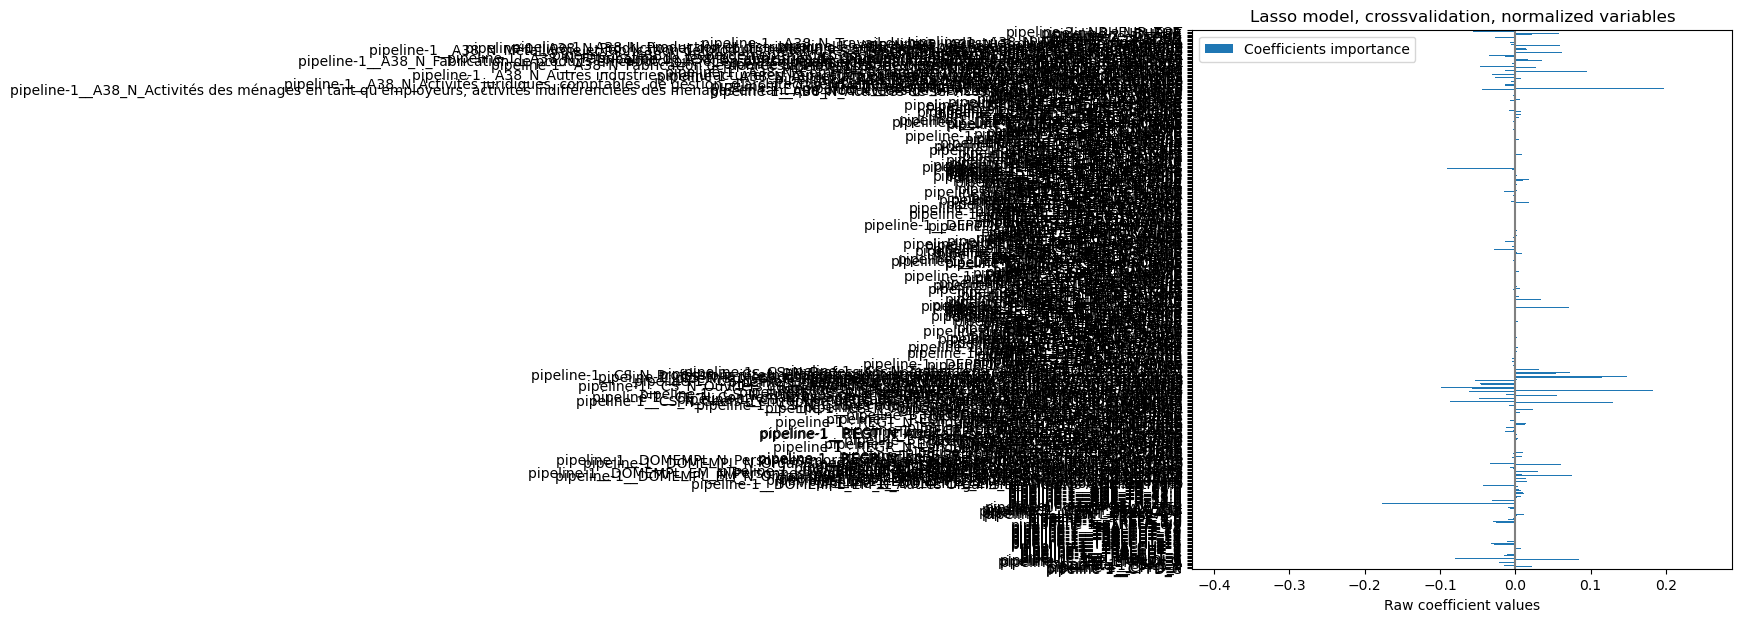

In [25]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, crossvalidation, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In order to understand how many variables were penalized by the Lasso selection, we make a histogram of the values of the coefficients.
122 coefficients out of 270 were put to zero. There was a significant selection.

Text(0.5, 1.0, 'Distribution of the Lasso coefficients')

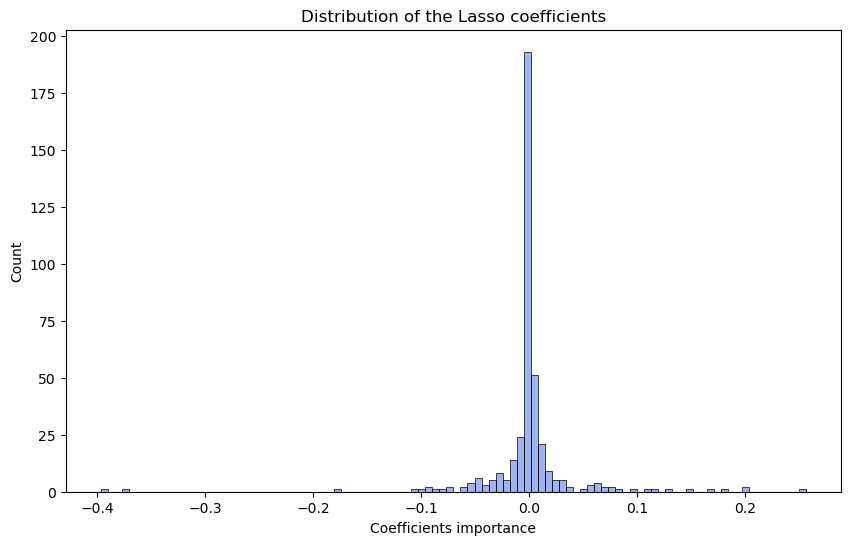

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(coefs["Coefficients importance"], bins=100, color = 'royalblue', alpha = 0.5)
plt.title('Distribution of the Lasso coefficients')

In [28]:
coefs["Coefficients importance"].value_counts()

Coefficients importance
 0.000000    122
 0.000210      1
-0.002881      1
-0.005434      1
 0.017654      1
            ... 
-0.000393      1
-0.001792      1
 0.010487      1
-0.007109      1
-0.019523      1
Name: count, Length: 270, dtype: int64

Now, we select and plot the 10 greatest coefficients and the coefficient of the variable Sex in order to understand which variables are significant determinants of the wage. The most important ones are:
- FILT2 which indicates that the job is "annex" (under a threshold of wage and working hours) and is related to the number of hours
- categories of jobs :
    - DOMEMPL: particuliers employeurs: aide à domicile, service à la personne : femmes de ménages, valets
    - DOMEMPL divided in A38: QB 60 % and TZ 40% :
      QB: hébergement médico-social : collectivités, aides soignantes, éducateurs spécialisés, etc. 
      TZ: activité des ménages en tant qu'employeurs : personnel domestique : valets, femmes de ménages, palefrenier
    - CS: managers and executives of the private and public sectors
- being young (15-19 years-old)
- sex: less important but being a woman still reduces the wage by 2%.

In [29]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(10)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row

Coefficients importance  \
pipeline-1__FILT_2                                                -0.396156   
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs                  -0.370847   
pipeline-2__NBHEUR_TOT                                             0.255854   
pipeline-1__CS_N_Cadres administratifs et comme...                 0.200859   
pipeline-1__A38_N_Activités des ménages en tant...                 0.197706   
pipeline-1__CS_N_Ingénieurs et cadres technique...                 0.183354   
pipeline-1__AGE_TR_19.0                                           -0.177655   
pipeline-1__CS_N_Professions libérales (exercée...                 0.166985   
pipeline-1__CS_N_Professions de l'information, ...                 0.148611   
pipeline-1__CS_N_Cadres de la fonction publique                    0.130347   
pipeline-1__SEXE_2                                                -0.021554   

                                                    abs_coefs  
pipeline-1__FILT_2                                   0.396156  
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs     0.370847  
pipeline-2__NBHEUR_TOT                               0.255854  
pipeline-1__CS_N_Cadres administratifs et comme...   0.200859  
pipeline-1__A38_N_Activités des ménages en tant...   0.197706  
pipeline-1__CS_N_Ingénieurs et cadres technique...   0.183354  
pipeline-1__AGE_TR_19.0                              0.177655  
pipeline-1__CS_N_Professions libérales (exercée...   0.166985  
pipeline-1__CS_N_Professions de l'information, ...   0.148611  
pipeline-1__CS_N_Cadres de la fonction publique      0.130347  
pipeline-1__SEXE_2                                   0.021554

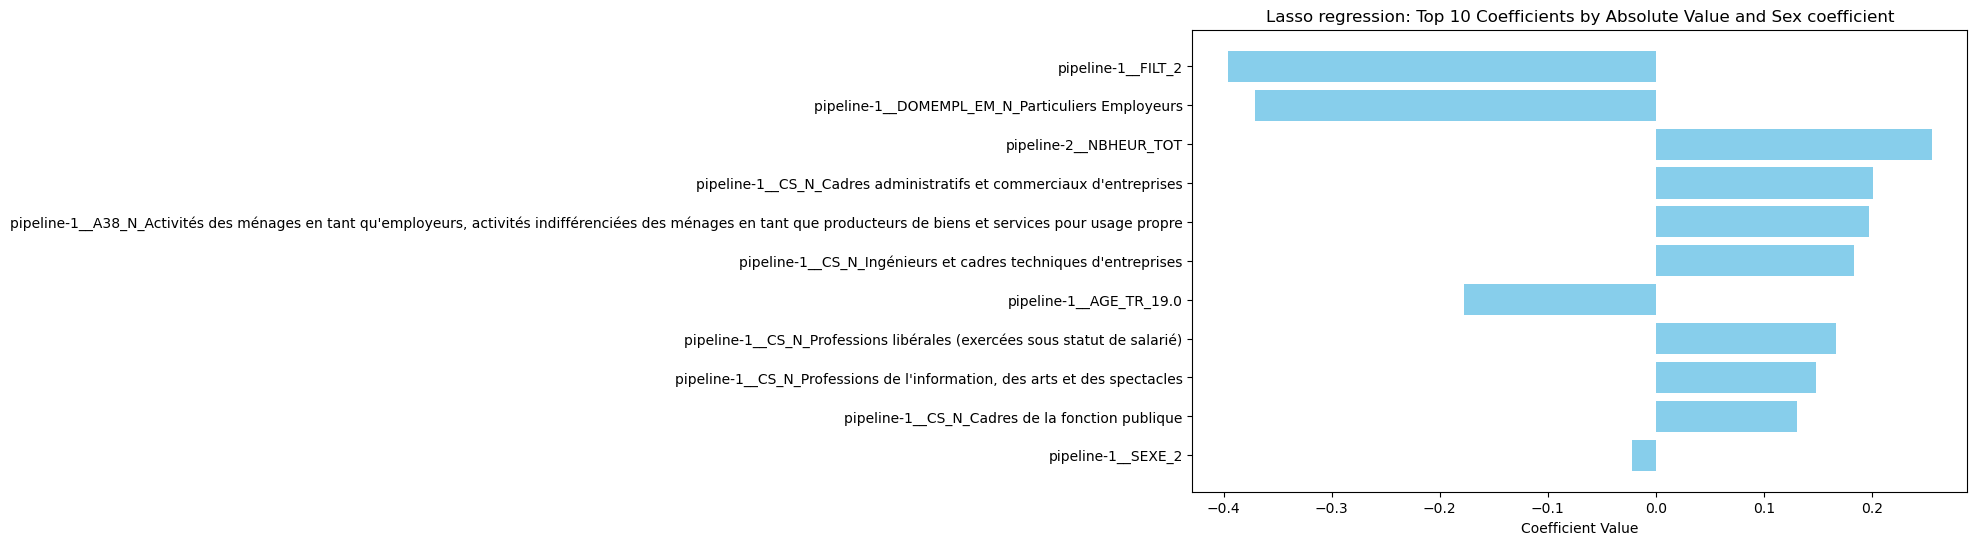

In [30]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso regression: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()


In [31]:
# Then we check the quality of the predictions.

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}


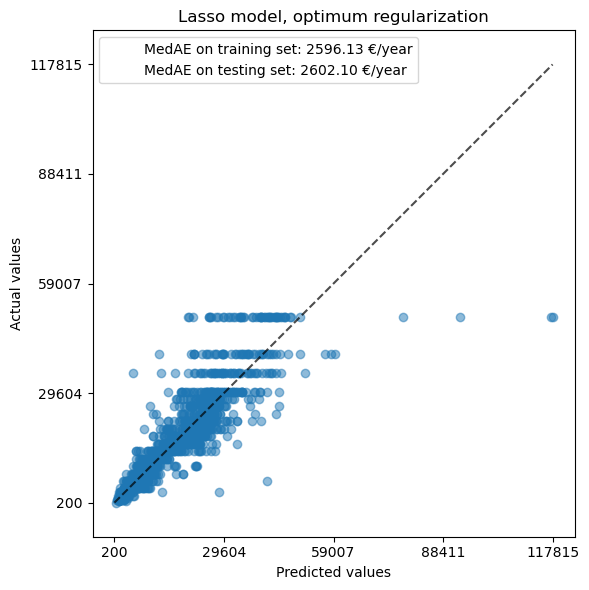

In [32]:
_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

## Then, we try the Lasso with the variables selected by the DAG

We consider less variables because we remove the "post-treatment" variables. Variables such as the time worked in a year or the socio-professionnal category depend heavily on gender. 

In [23]:
base["AGE_SQ"]=base['AGE']**2

In [25]:
target = ['WAGE']
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE',
    "AGE_SQ" #age en années
]

categorical_columns = [
    'SEXE', #1 homme 2 femme
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'DOMEMPL_EM_N', 'DOMEMPL_N',
    'DEPT_N'
]

all_columns = numerical_columns + categorical_columns

In [26]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

There are less variables so we increased the number of maximum iterations, there are less issues with convergence.

In [28]:
alphas = np.logspace(-5, 5, 11)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=500, n_jobs=-1),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [29]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.54124925629003, tolerance: 22.298806012091386

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 399.4276110580686, tolerance: 22.30515189093643

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.42086021024443, tolerance: 22.328541517180028

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 276.2321862007375, tolerance: 22.2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['SEXE', 'TREFF',
                                                   'DOMEMPL_EM_N', 'DOMEMPL_N',
                                                   'DEPT_N']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DATDEB', 'DATFIN', 'AGE',
                                                   'AGE_SQ'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                                                              max_iter=500,
                                                              n_jobs=-1)))])

In [30]:
alpha_cv_lasso = model[-1].regressor_.alpha_
alpha_cv_lasso

np.float64(9.999999999999999e-06)

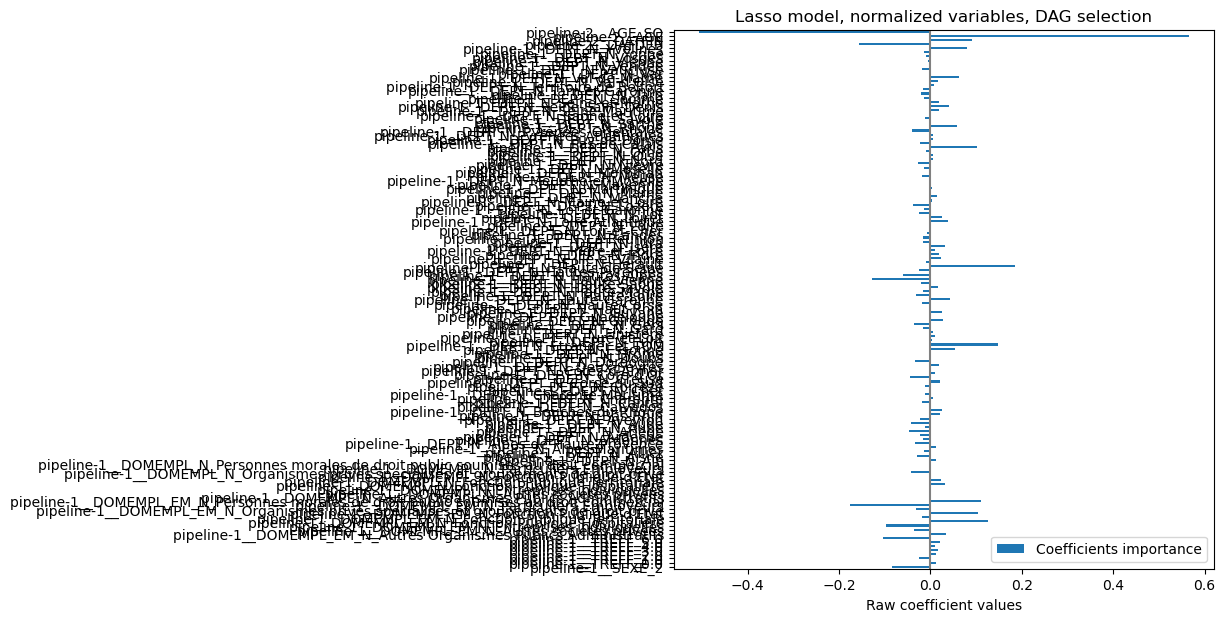

In [31]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, normalized variables, DAG selection")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [32]:
coefs["Coefficients importance"].value_counts()

Coefficients importance
 0.000000    9
 0.011507    1
-0.084855    1
 0.011755    1
 0.016505    1
            ..
 0.079375    1
-0.156358    1
 0.091864    1
 0.566691    1
-0.507440    1
Name: count, Length: 123, dtype: int64

By removing the variables that are heavily influenced by gender (such as the socio-professionnal category), we can see that gender has an important impact on wage that goes through the choice of the job. Now, being a woman reduces the wage by 8%, but we are not interpreting this result all things being equal. 

In [33]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(10)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

# Re-sort if needed (optional), in case the specific row's coefficient value was smaller than the current top 10
top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row


Coefficients importance  \
pipeline-2__AGE                                                    0.566691   
pipeline-2__AGE_SQ                                                -0.507440   
pipeline-1__DEPT_N_Hauts-de-Seine                                  0.185512   
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs                  -0.175339   
pipeline-2__DATDEB                                                -0.156358   
pipeline-1__DEPT_N_Etranger et TOM                                 0.147479   
pipeline-1__DEPT_N_Haute-Vienne                                   -0.127556   
pipeline-1__DOMEMPL_EM_N_Fonction Publique Hosp...                 0.126592   
pipeline-1__DOMEMPL_EM_N_Personnes morales de d...                 0.109733   
pipeline-1__DOMEMPL_EM_N_Fonction Publique d'Etat                  0.104568   
pipeline-1__SEXE_2                                                -0.084855   

                                                    abs_coefs  
pipeline-2__AGE                                      0.566691  
pipeline-2__AGE_SQ                                   0.507440  
pipeline-1__DEPT_N_Hauts-de-Seine                    0.185512  
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs     0.175339  
pipeline-2__DATDEB                                   0.156358  
pipeline-1__DEPT_N_Etranger et TOM                   0.147479  
pipeline-1__DEPT_N_Haute-Vienne                      0.127556  
pipeline-1__DOMEMPL_EM_N_Fonction Publique Hosp...   0.126592  
pipeline-1__DOMEMPL_EM_N_Personnes morales de d...   0.109733  
pipeline-1__DOMEMPL_EM_N_Fonction Publique d'Etat    0.104568  
pipeline-1__SEXE_2                                   0.084855

In [47]:
features_important=top_10_with_specific_row.index

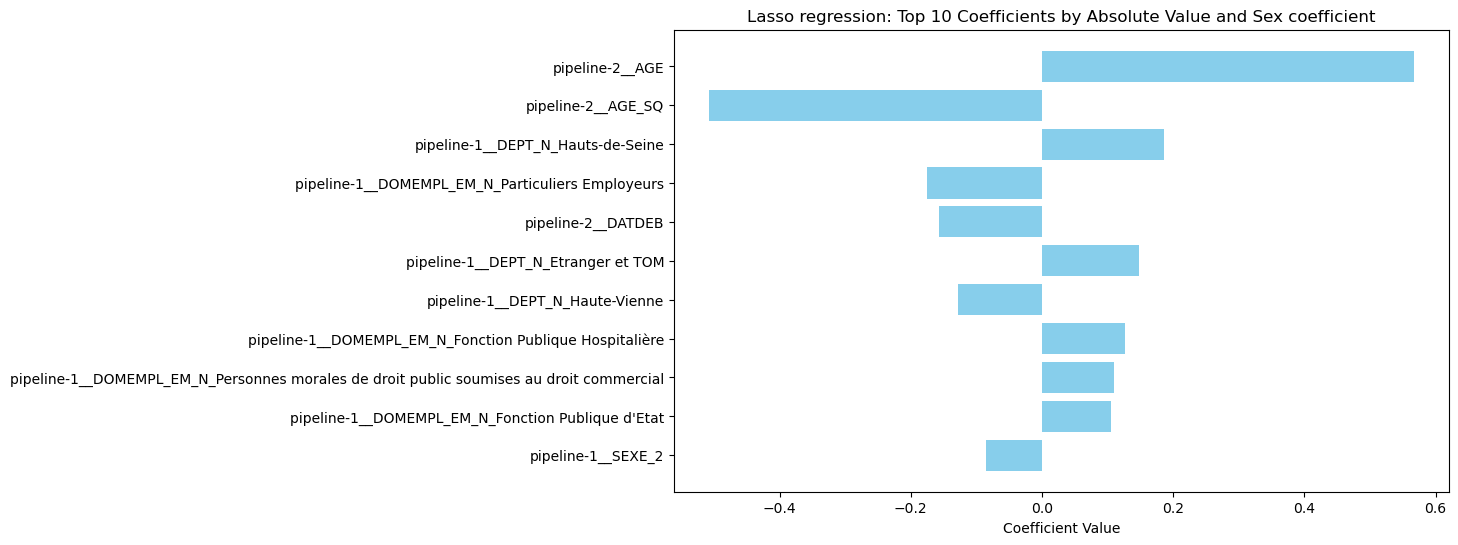

In [34]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso regression: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()

The coefficient of Sex is more important than when we were controlling for occupation and time worked because we are interested in the global causal effect. 
Nevertheless, it is still less important than other variables such as age of the department. 

In [35]:
# Then we check the quality of the predictions.

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}


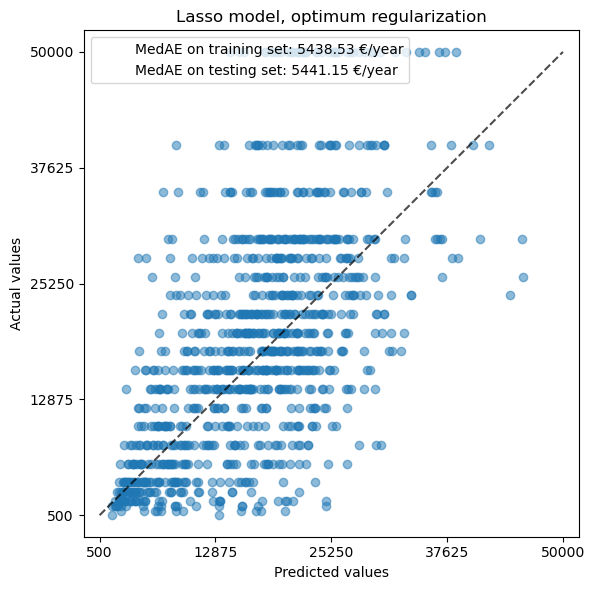

In [36]:
_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

Removing variables makes the predictions less precise, the median absolute error is way larger. 

### Cross validation to check coefficient variability

We take the alpha coefficient selected by the first Lasso to reduce the fiting time on every fold.

In [40]:
alpha_cv_lasso = np.float64(9.999999999999999e-06)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=alpha_cv_lasso),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [53]:
cv = RepeatedKFold(n_splits=2, n_repeats=3, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.119886580563616, tolerance: 18.542002658466757
  model = cd_fast.sparse_enet_coordinate_descent(


In [56]:
feature_names= model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

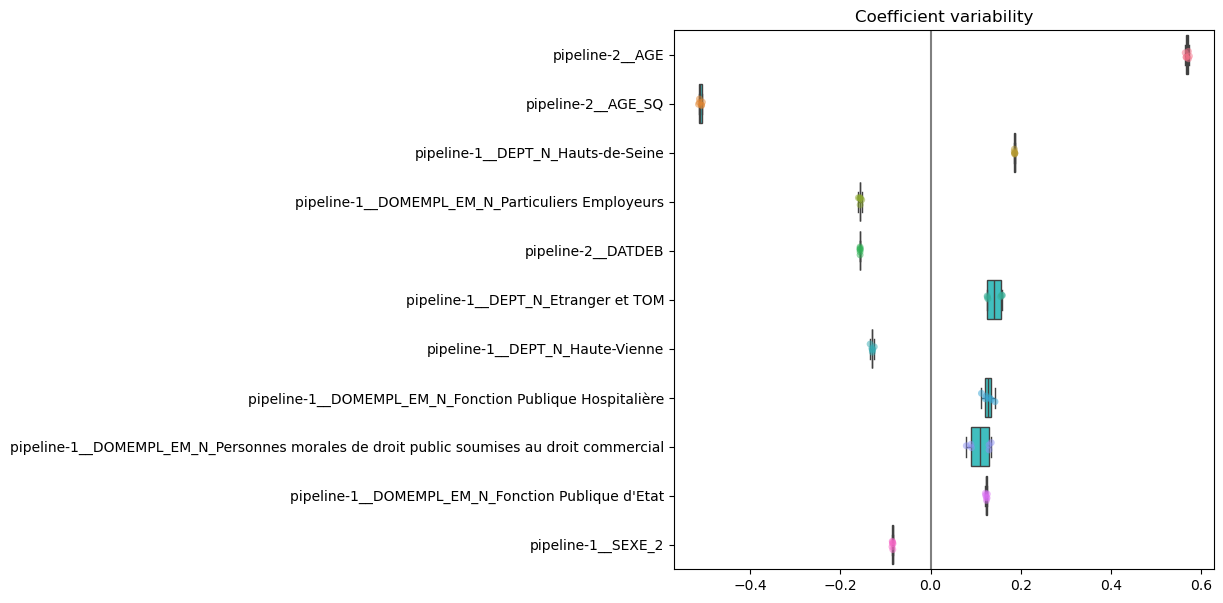

In [57]:
plt.figure(figsize=(9,7))
sns.stripplot(data=coefs[features_important], orient = "h", alpha=0.5)
sns.boxplot(data=coefs[features_important], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

## tenter Ridge removing highly correlated features and doing CV

In [67]:
target = ['WAGE']
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE',
    'AGE_SQ', #age en années
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total 
]

categorical_columns = [
    'CPFD', #temps complet ou partiel
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    'SEXE', #1 homme 2 femme
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'DOMEMPL_EM_N', 'DOMEMPL_N',
    'CS_N', 'DEPT_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

In [68]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [69]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [71]:


alphas = np.logspace(-5, 5, 11)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['CPFD', 'FILT', 'SEXE',
                                                   'TYP_EMPLOI', 'TRALCHT',
                                                   'TREFF', 'CONT_TRAV',
                                                   'DOMEMPL_EM_N', 'DOMEMPL_N',
                                                   'CS_N', 'DEPT_N']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[(...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DATDEB', 'DATFIN', 'AGE',
                                                   'AGE_SQ', 'DUREE', 'NBHEUR',
                                                   'NBHEUR_TOT'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]))))])

In [72]:
alpha_cv_ridge = model[-1].regressor_.alpha_
alpha_cv_ridge

np.float64(10.0)

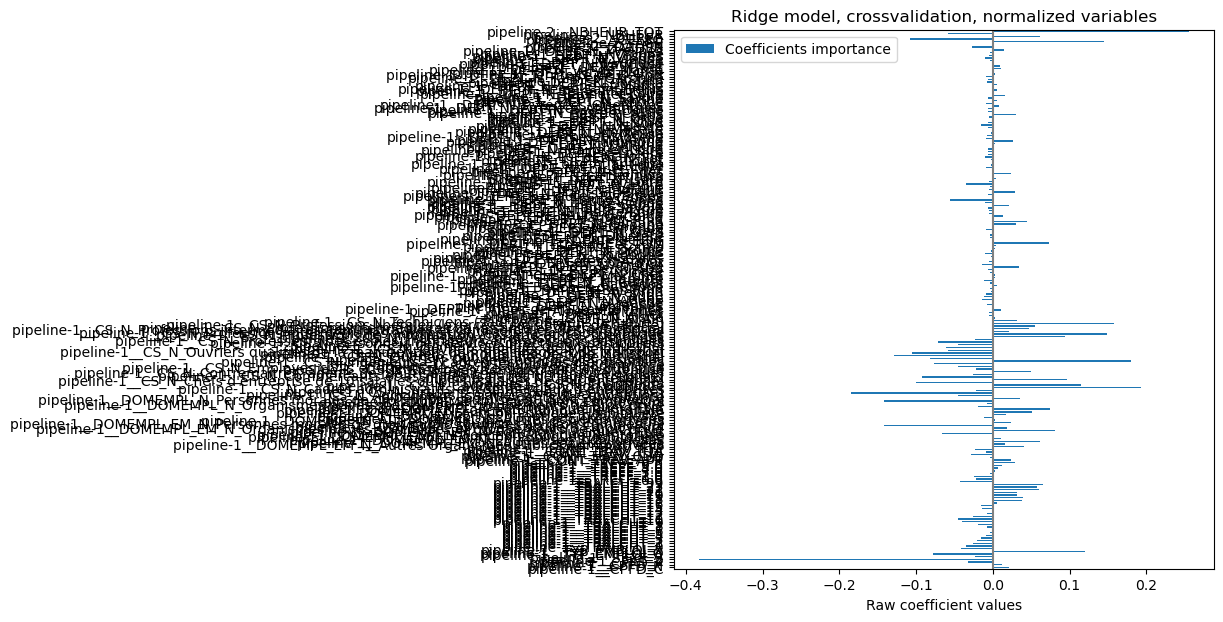

In [73]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, crossvalidation, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [74]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(10)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

# Re-sort if needed (optional), in case the specific row's coefficient value was smaller than the current top 10
top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row

Coefficients importance  \
pipeline-1__FILT_2                                                -0.383500   
pipeline-2__NBHEUR_TOT                                             0.256174   
pipeline-1__CS_N_Cadres administratifs et comme...                 0.192592   
pipeline-1__CS_N_Agriculteurs (salariés de leur...                -0.185013   
pipeline-1__CS_N_Ingénieurs et cadres technique...                 0.180159   
pipeline-1__CS_N_Professions libérales (exercée...                 0.158413   
pipeline-1__CS_N_Professions de l'information, ...                 0.148379   
pipeline-2__AGE                                                    0.145507   
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs                  -0.141950   
pipeline-1__DOMEMPL_N_Particuliers Employeurs                     -0.141950   
pipeline-1__SEXE_2                                                -0.022602   

                                                    abs_coefs  
pipeline-1__FILT_2                                   0.383500  
pipeline-2__NBHEUR_TOT                               0.256174  
pipeline-1__CS_N_Cadres administratifs et comme...   0.192592  
pipeline-1__CS_N_Agriculteurs (salariés de leur...   0.185013  
pipeline-1__CS_N_Ingénieurs et cadres technique...   0.180159  
pipeline-1__CS_N_Professions libérales (exercée...   0.158413  
pipeline-1__CS_N_Professions de l'information, ...   0.148379  
pipeline-2__AGE                                      0.145507  
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs     0.141950  
pipeline-1__DOMEMPL_N_Particuliers Employeurs        0.141950  
pipeline-1__SEXE_2                                   0.022602

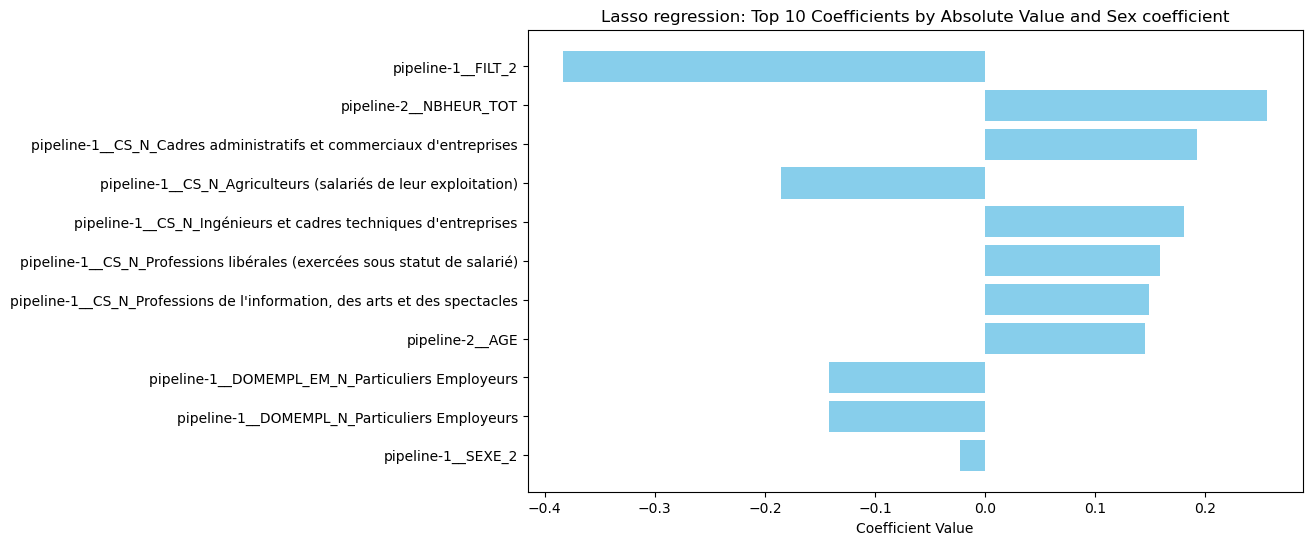

In [75]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso regression: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()

In [76]:
# Then we check the quality of the predictions.

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}


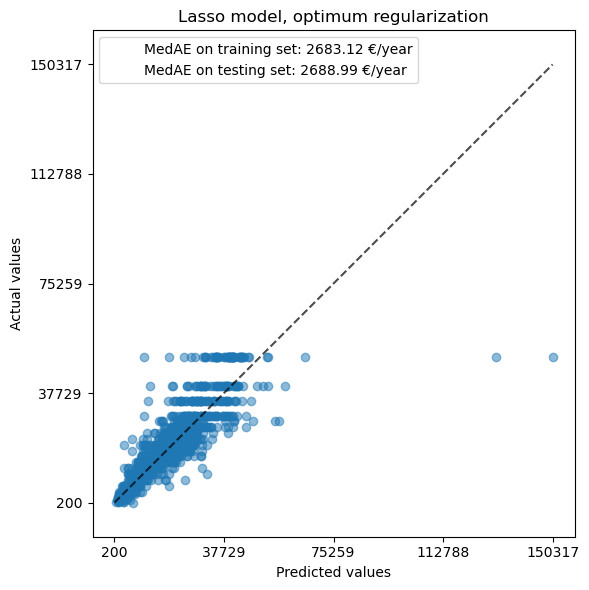

In [77]:
_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [78]:
cv = RepeatedKFold(n_splits=2, n_repeats=4, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)

In [79]:
feature_names= model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

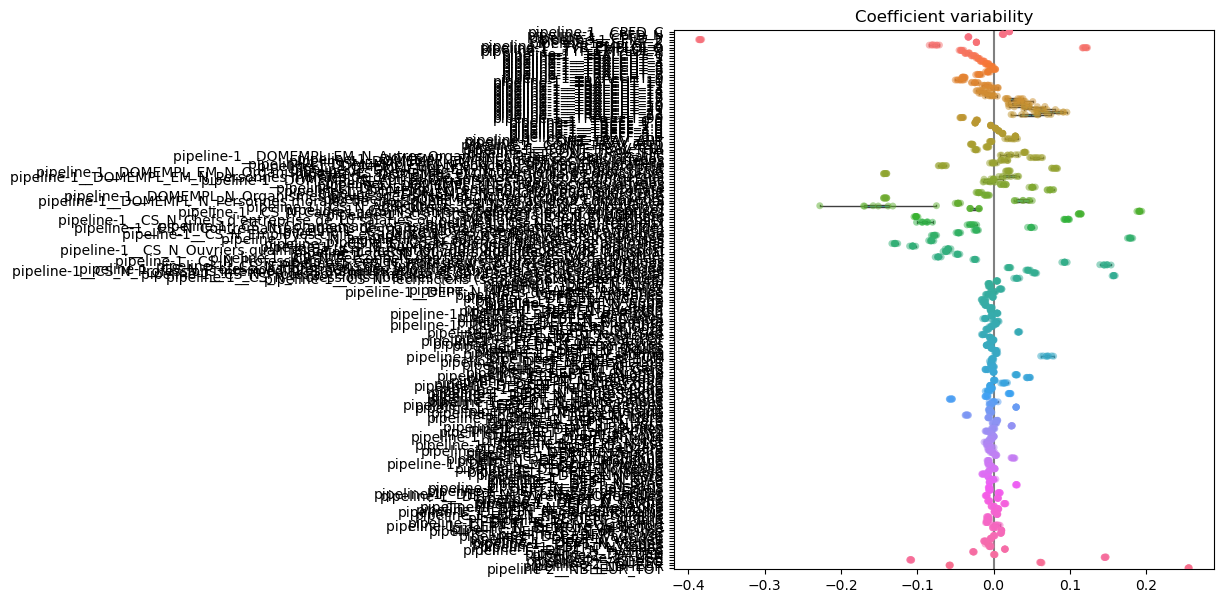

In [81]:
plt.figure(figsize=(9,7))
sns.stripplot(data=coefs, orient = "h", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

In [85]:
top_10_std = coefs.std().nlargest(20).index
top_10_std

Index(['pipeline-1__CS_N_Agriculteurs (salariés de leur exploitation)',
       'pipeline-1__TRALCHT_23', 'pipeline-1__TRALCHT_22',
       'pipeline-1__TRALCHT_20', 'pipeline-1__TRALCHT_21',
       'pipeline-1__TRALCHT_19',
       'pipeline-1__DOMEMPL_EM_N_Personnes morales de droit public soumises au droit commercial',
       'pipeline-1__TRALCHT_17', 'pipeline-1__TRALCHT_18',
       'pipeline-1__DOMEMPL_N_Personnes morales de droit public soumises au droit commercial',
       'pipeline-1__DOMEMPL_EM_N_Autres Organismes Publics Administratifs',
       'pipeline-1__DOMEMPL_N_Autres Organismes Publics Administratifs',
       'pipeline-1__CS_N_Clergé, religieux',
       'pipeline-1__CS_N_Artisans (salariés de leur entreprise)',
       'pipeline-1__DOMEMPL_EM_N_Autres sociétés privées',
       'pipeline-1__TRALCHT_15',
       'pipeline-1__DOMEMPL_N_Autres sociétés privées',
       'pipeline-1__CONT_TRAV_APP', 'pipeline-1__DEPT_N_Etranger et TOM',
       'pipeline-1__TRALCHT_16'],
      dty

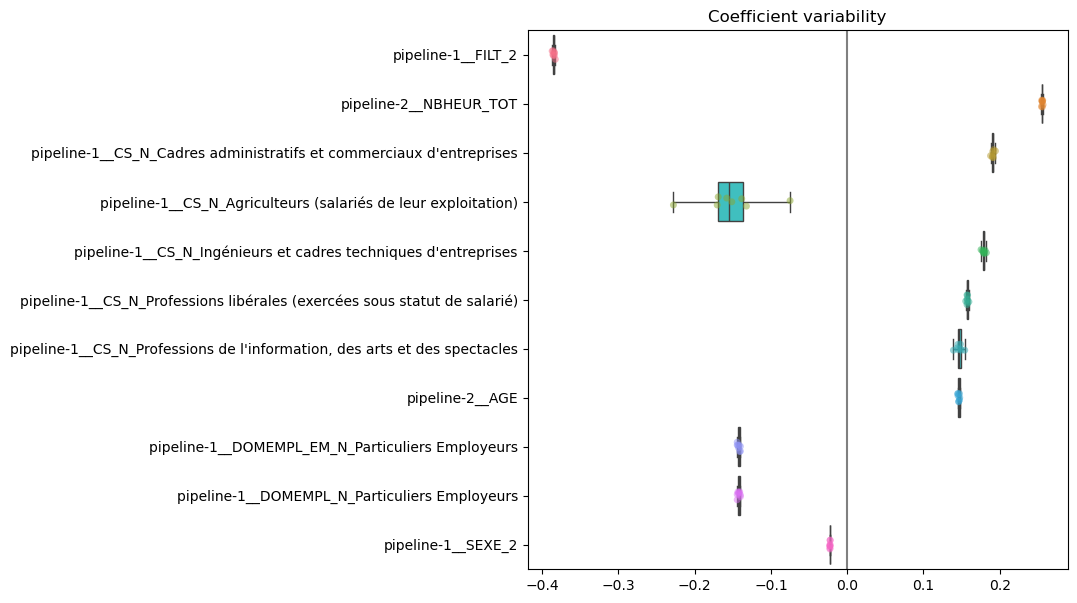

In [86]:
features_important=top_10_with_specific_row.index
plt.figure(figsize=(9,7))
sns.stripplot(data=coefs[features_important], orient = "h", alpha=0.5)
sns.boxplot(data=coefs[features_important], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

## Heterogeneity analysis: different effect of the variables depending on the type of contract

Is the effect of covariates (including gender) on wages the same for part-time and full-time employees ?

We are going to do a preliminary analysis of the heterogeneity of effects by estimating the model on subsamples of employees depending on their type of contract. This analysis is not necessarily robust mathematically, but it can give us an idea of how the effect varies.

First, we estimate the model on full-time workers.

In [108]:
base_complet= base.loc[base['CPFD']== "C"]
print(f"Number of rows : {base_complet.shape[0]}, this represents {base_complet.shape[0]/base.shape[0]*100}% of the original database. ")

Number of rows : 1838140, this represents 76.46888747906938% of the original database. 


In [ ]:
target = ['WAGE']
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE',
    'AGE_SQ', #age en années
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total 
]

categorical_columns = [
    'CPFD', #temps complet ou partiel
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    'SEXE', #1 homme 2 femme
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'DOMEMPL_EM_N', 'DOMEMPL_N',
    'CS_N', 'DEPT_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

In [104]:
X = base_complet[all_columns]
X.describe(include="all")
base_complet.loc[base_complet['WAGE'] == 0, 'WAGE'] = 1
y = base_complet['WAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [96]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [97]:
alphas = np.logspace(-5, 5, 11)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['CPFD', 'FILT', 'SEXE',
                                                   'TYP_EMPLOI', 'TRALCHT',
                                                   'TREFF', 'CONT_TRAV',
                                                   'DOMEMPL_EM_N', 'DOMEMPL_N',
                                                   'CS_N', 'DEPT_N']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[(...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DATDEB', 'DATFIN', 'AGE',
                                                   'AGE_SQ', 'DUREE', 'NBHEUR',
                                                   'NBHEUR_TOT'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]))))])

In [98]:
alpha_cv_ridge = model[-1].regressor_.alpha_
alpha_cv_ridge

np.float64(10.0)

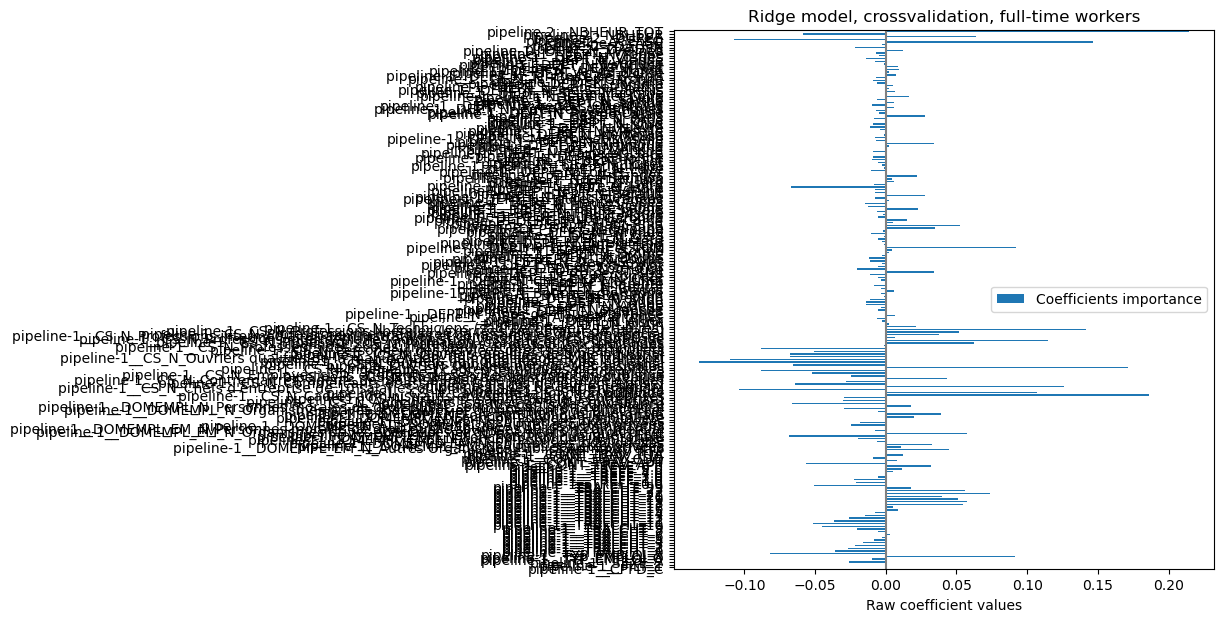

In [105]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, crossvalidation, full-time workers")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [101]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(10)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row

Coefficients importance  \
pipeline-2__NBHEUR_TOT                                             0.214771   
pipeline-1__CS_N_Cadres administratifs et comme...                 0.186036   
pipeline-1__CS_N_Ingénieurs et cadres technique...                 0.171243   
pipeline-2__AGE                                                    0.146740   
pipeline-1__CS_N_Professions libérales (exercée...                 0.141443   
pipeline-1__CS_N_Ouvriers non qualifiés de type...                -0.132392   
pipeline-1__CS_N_Chefs d'entreprise de 10 salar...                 0.126258   
pipeline-1__CS_N_Professions de l'information, ...                 0.114914   
pipeline-1__CS_N_Ouvriers non qualifiés de type...                -0.110347   
pipeline-1__CS_N_Cadres de la fonction publique                    0.107193   
pipeline-1__SEXE_2                                                -0.026028   

                                                    abs_coefs  
pipeline-2__NBHEUR_TOT                               0.214771  
pipeline-1__CS_N_Cadres administratifs et comme...   0.186036  
pipeline-1__CS_N_Ingénieurs et cadres technique...   0.171243  
pipeline-2__AGE                                      0.146740  
pipeline-1__CS_N_Professions libérales (exercée...   0.141443  
pipeline-1__CS_N_Ouvriers non qualifiés de type...   0.132392  
pipeline-1__CS_N_Chefs d'entreprise de 10 salar...   0.126258  
pipeline-1__CS_N_Professions de l'information, ...   0.114914  
pipeline-1__CS_N_Ouvriers non qualifiés de type...   0.110347  
pipeline-1__CS_N_Cadres de la fonction publique      0.107193  
pipeline-1__SEXE_2                                   0.026028

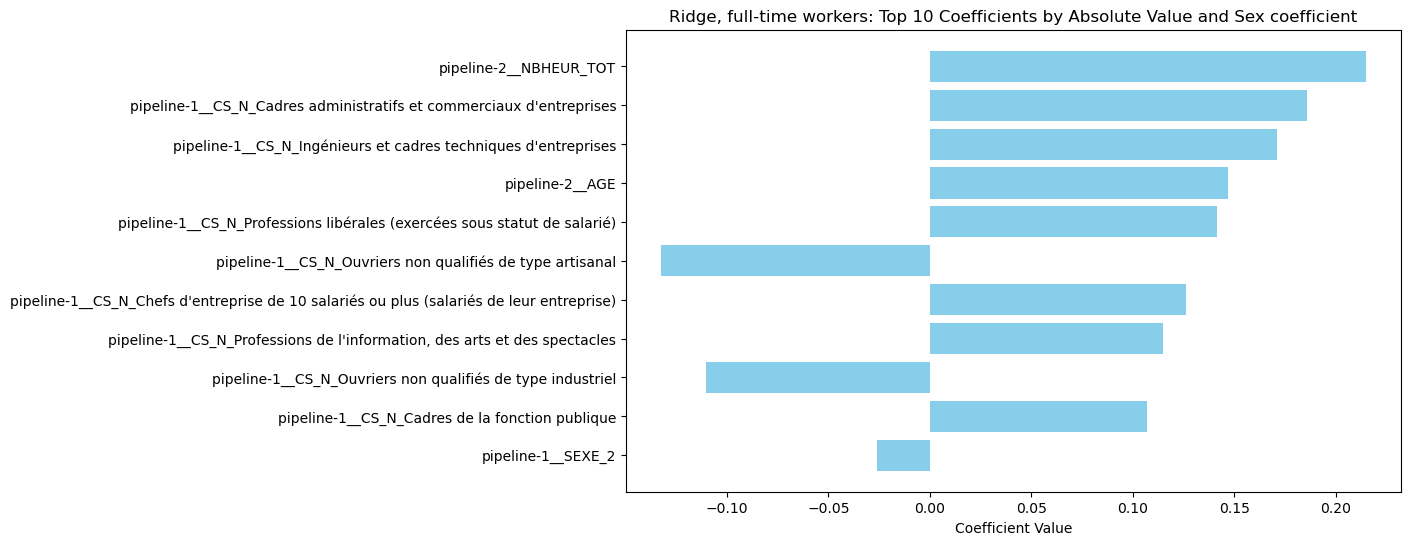

In [106]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Ridge, full-time workers: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()

Now, we estimate the model on part-time workers.

In [107]:
base_partiel= base.loc[base['CPFD']== "P"]
print(f"Number of rows : {base_partiel.shape[0]}, this represents {base_partiel.shape[0]/base.shape[0]*100}% of the original database. ")

Number of rows : 354944, this represents 14.766107476781313% of the original database. 


In [109]:
X = base_partiel[all_columns]
X.describe(include="all")
base_partiel.loc[base_partiel['WAGE'] == 0, 'WAGE'] = 1
y = base_partiel['WAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [110]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [111]:
alphas = np.logspace(-5, 5, 11)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['CPFD', 'FILT', 'SEXE',
                                                   'TYP_EMPLOI', 'TRALCHT',
                                                   'TREFF', 'CONT_TRAV',
                                                   'DOMEMPL_EM_N', 'DOMEMPL_N',
                                                   'CS_N', 'DEPT_N']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[(...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DATDEB', 'DATFIN', 'AGE',
                                                   'AGE_SQ', 'DUREE', 'NBHEUR',
                                                   'NBHEUR_TOT'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]))))])

In [112]:
alpha_cv_ridge = model[-1].regressor_.alpha_
alpha_cv_ridge

np.float64(10.0)

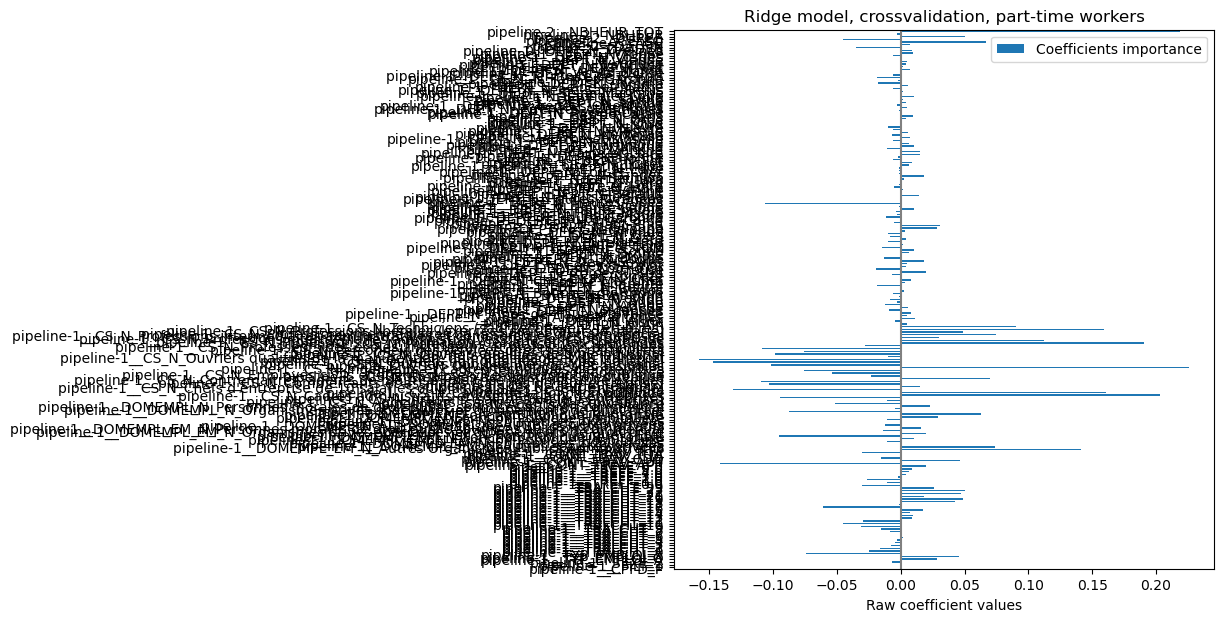

In [114]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, crossvalidation, part-time workers")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [119]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(10)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

# Re-sort if needed (optional), in case the specific row's coefficient value was smaller than the current top 10
top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row

Coefficients importance  \
pipeline-1__CS_N_Ingénieurs et cadres technique...                 0.226173   
pipeline-2__NBHEUR_TOT                                             0.219040   
pipeline-1__CS_N_Cadres administratifs et comme...                 0.203004   
pipeline-1__CS_N_Professeurs, professions scien...                 0.190924   
pipeline-1__CS_N_Cadres de la fonction publique                    0.160876   
pipeline-1__CS_N_Professions libérales (exercée...                 0.158961   
pipeline-1__CS_N_Ouvriers non qualifiés de type...                -0.158355   
pipeline-1__CS_N_Ouvriers non qualifiés de type...                -0.147214   
pipeline-1__CONT_TRAV_TTP                                          0.141448   
pipeline-1__CONT_TRAV_APP                                         -0.141378   
pipeline-1__SEXE_2                                                -0.006521   

                                                    abs_coefs  
pipeline-1__CS_N_Ingénieurs et cadres technique...   0.226173  
pipeline-2__NBHEUR_TOT                               0.219040  
pipeline-1__CS_N_Cadres administratifs et comme...   0.203004  
pipeline-1__CS_N_Professeurs, professions scien...   0.190924  
pipeline-1__CS_N_Cadres de la fonction publique      0.160876  
pipeline-1__CS_N_Professions libérales (exercée...   0.158961  
pipeline-1__CS_N_Ouvriers non qualifiés de type...   0.158355  
pipeline-1__CS_N_Ouvriers non qualifiés de type...   0.147214  
pipeline-1__CONT_TRAV_TTP                            0.141448  
pipeline-1__CONT_TRAV_APP                            0.141378  
pipeline-1__SEXE_2                                   0.006521

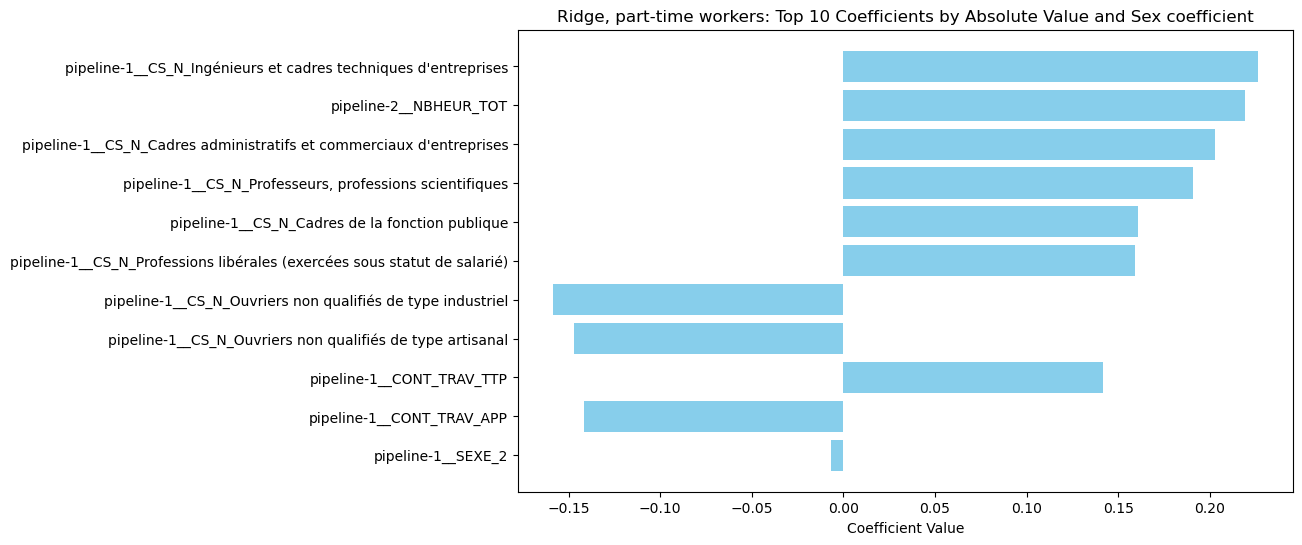

In [117]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Ridge, part-time workers: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()

Comments on the differences in coefficients by type of contract: 
- for part-time workers, the socio-professionnal category has a larger impact on the wage than for full-time workers
- for part-time workers, age is less important for the wage, to the point that it is not in the top10 of coefficients. On the contrary, it is the 4th highest coefficient that determines the wage level for full-time workers.
- We can also see that for part-time workers, the type of contract matters a lot ("interim" increases the wage, while "apprentissage" decreases it)
- Regarding the impact of sex, it is highly heterogeneous depending on being a full-time or part-time worker. Our analysis is not causal here because there are probably a lot of selection bias, especially because being on a part-time contract is highly correlated with being a woman. But we can still underline the fact that for full-time workers, being a woman decreases wages by 2.6% while this effect is only 0.6% for part-time workers. 